In [ ]:
!pip install -q lightgbm xgboost imbalanced-learn shap --quiet

In [ ]:
# CELL 1 - Config & Imports
import os, gc, time, math, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import shap

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
sns.set_style('whitegrid')

# Safety switch: set True to use lightweight mode (faster, lower memory).
FAST_MODE = False   # <--- set True if Colab still runs out of memory


In [ ]:
# CELL 2 - Mount Google Drive & set paths
from google.colab import drive
drive.mount('/content/drive')

BASE = '/content/drive/MyDrive/ML/'   # change if your folder differs
TRAIN_PATH = os.path.join(BASE, 'train_transaction.csv')
TEST_PATH  = os.path.join(BASE, 'test_transaction.csv')
SUBMIT_PATH = os.path.join(BASE, 'submission_lgb_stacked.csv')

assert os.path.exists(TRAIN_PATH), f"Train file not found: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH),  f"Test file not found: {TEST_PATH}"
print("Paths OK.")


Mounted at /content/drive
Paths OK.


In [ ]:
# CELL 3 - Memory helpers
def reduce_memory(df, aggressive=True):
    start_mem = df.memory_usage().sum()/1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type == 'float64':
            df[col] = df[col].astype('float32')
        elif col_type == 'int64':
            df[col] = df[col].astype('int32')
        elif col_type == 'object' and aggressive:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum()/1024**2
    print(f"Mem: {start_mem:.2f} MB -> {end_mem:.2f} MB")
    return df

def clear():
    gc.collect()


In [ ]:
# CELL 4 - Load data (with optional sampling to reduce memory)
SAMPLE_FRAC = 1.0   # set <1.0 to randomly sample train for debugging (e.g., 0.5)
print("Loading data...")
train = pd.read_csv(TRAIN_PATH, low_memory=False)
test  = pd.read_csv(TEST_PATH,  low_memory=False)
print("Original shapes:", train.shape, test.shape)
if SAMPLE_FRAC < 1.0:
    train = train.sample(frac=SAMPLE_FRAC, random_state=RANDOM_STATE).reset_index(drop=True)
print("After sampling (if any):", train.shape)
reduce_memory(train); reduce_memory(test)
clear()


Loading data...
Original shapes: (590540, 394) (506691, 393)
After sampling (if any): (590540, 394)
Mem: 1775.15 MB -> 863.93 MB
Mem: 1519.24 MB -> 739.33 MB


In [ ]:
# CELL 5 - Quick EDA: class balance and missing %
print("isFraud distribution:")
print(train['isFraud'].value_counts(normalize=True))
miss = train.isna().mean().sort_values(ascending=False)
print("\nTop missing columns (>%):")
display(miss.head(20))


isFraud distribution:
isFraud
0    0.96501
1    0.03499
Name: proportion, dtype: float64

Top missing columns (>%):


,0
dist2,0.936284
D7,0.934099
D13,0.895093
D14,0.894695
D12,0.890410
D6,0.876068
D9,0.873123
D8,0.873123
V153,0.861237
V149,0.861237


In [ ]:
# CELL 6 - Drop cols with extremely high missingness and light impute (FIXED)
DROP_MISSING_THRESH = 0.75   # drop columns with >75% missing
cols_to_drop = miss[miss > DROP_MISSING_THRESH].index.tolist()

print("Dropping columns with >{:.0%} missing: {} cols".format(DROP_MISSING_THRESH, len(cols_to_drop)))
train.drop(columns=cols_to_drop, inplace=True, errors='ignore')
test.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# remove target column from processing lists
TARGET = "isFraud"

num_cols = train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = train.select_dtypes(include=['object','category']).columns.tolist()

# Safety: ensure TARGET not included in num_cols or cat_cols
if TARGET in num_cols: num_cols.remove(TARGET)
if TARGET in cat_cols: cat_cols.remove(TARGET)

print(f"Num cols: {len(num_cols)}, Cat cols: {len(cat_cols)}")

# ---- Numeric Fill ----
for c in num_cols:
    med = train[c].median()
    train[c].fillna(med, inplace=True)
    if c in test.columns:
        test[c].fillna(med, inplace=True)

# ---- Categorical Fill  ----
for c in cat_cols:
    # Convert Categorical -> Object to avoid category restriction error
    train[c] = train[c].astype('object')
    if c in test.columns:
        test[c] = test[c].astype('object')

    train[c].fillna('missing', inplace=True)
    if c in test.columns:
        test[c].fillna('missing', inplace=True)


# reduce memory after filling
reduce_memory(train)
reduce_memory(test)
clear()


Dropping columns with >75% missing: 168 cols
Num cols: 212, Cat cols: 13


/tmp/ipython-input-2587567739.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[c].fillna(med, inplace=True)
/tmp/ipython-input-2587567739.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.meth

Mem: 538.40 MB -> 487.16 MB
Mem: 460.02 MB -> 416.06 MB


In [ ]:
# CELL 7 - Feature engineering (safe operations)
def fe_basic(df):
    df = df.copy()
    if 'TransactionAmt' in df.columns:
        df['TransactionAmt_log'] = np.log1p(df['TransactionAmt'].astype(float))
    if 'TransactionDT' in df.columns:
        df['DT_hour'] = (df['TransactionDT'] // 3600) % 24
        df['DT_day']  = (df['TransactionDT'] // (24*3600)) % 7
    # combine a few card features if exist
    for a,b in [('card1','card2'),('card3','card4')]:
        if a in df.columns and b in df.columns:
            df[f'{a}_{b}'] = df[a].astype(str) + '_' + df[b].astype(str)
    return df

print("Applying FE...")
train = fe_basic(train)
test  = fe_basic(test)
reduce_memory(train); reduce_memory(test)
clear()
print("FE done. shapes:", train.shape, test.shape)


Applying FE...
Mem: 505.18 MB -> 496.79 MB
Mem: 431.52 MB -> 424.41 MB
FE done. shapes: (590540, 231) (506691, 230)


In [ ]:
# CELL 8 - Encode categorical features in memory-safe way
from sklearn.preprocessing import LabelEncoder

def encode_train_test(train, test, onehot_threshold=10):
    train2 = train.copy()
    test2 = test.copy()
    cat_cols = train2.select_dtypes(include=['object','category']).columns.tolist()
    for c in cat_cols:
        full = pd.concat([train2[c].astype(str), test2[c].astype(str)], axis=0)
        n_unique = full.nunique()
        if n_unique <= onehot_threshold:
            d = pd.get_dummies(full, prefix=c)
            d1 = d.iloc[:len(train2)].reset_index(drop=True)
            d2 = d.iloc[len(train2):].reset_index(drop=True)
            train2 = pd.concat([train2.reset_index(drop=True).drop(columns=[c]), d1], axis=1)
            test2  = pd.concat([test2.reset_index(drop=True).drop(columns=[c]), d2], axis=1)
        else:
            le = LabelEncoder()
            le.fit(full)
            train2[c] = le.transform(train2[c].astype(str))
            test2[c]  = le.transform(test2[c].astype(str))
    # align columns
    train2, test2 = train2.align(test2, join='left', axis=1, fill_value=0)
    return train2, test2

print("Encoding...")
train_enc, test_enc = encode_train_test(train, test, onehot_threshold=10)
print("Encoded shapes:", train_enc.shape, test_enc.shape)
reduce_memory(train_enc); reduce_memory(test_enc)
clear()


Encoding...
Encoded shapes: (590540, 262) (506691, 262)
Mem: 524.32 MB -> 517.57 MB
Mem: 451.81 MB -> 444.08 MB


In [ ]:
# CELL 9 - Final feature selection
TARGET = 'isFraud'
ID_COL = 'TransactionID' if 'TransactionID' in train_enc.columns else None

features = [c for c in train_enc.columns if c != TARGET and c != ID_COL and c != 'TransactionDT']
print("Num features:", len(features))
X = train_enc[features]
y = train_enc[TARGET].astype(int)
X_test = test_enc[features]
test_ids = test_enc[ID_COL] if ID_COL in test_enc.columns else np.arange(len(X_test))


Num features: 259


In [ ]:
# CELL 10 - Class imbalance strategy (memory-safe)
print("Class balance:", y.value_counts(normalize=True).to_dict())

if FAST_MODE:
    # FAST: use LightGBM built-in scale_pos_weight
    use_smote = False
else:
    # prefer under + small smote to avoid explosion
    use_smote = True

if use_smote:
    print("Using RandomUnderSampler + small SMOTE to balance memory and performance.")
    rus = RandomUnderSampler(sampling_strategy=0.5, random_state=RANDOM_STATE)  # reduce majority
    X_rus, y_rus = rus.fit_resample(X, y)
    print("After undersample:", y_rus.value_counts())
    sm = SMOTE(sampling_strategy='auto', random_state=RANDOM_STATE)
    X_bal, y_bal = sm.fit_resample(X_rus, y_rus)
    print("After small SMOTE:", pd.Series(y_bal).value_counts())
    X_train_full, y_train_full = X_bal, y_bal
    del X_rus, y_rus, X_bal, y_bal
    clear()
else:
    # No resampling, use original X, but will pass scale_pos_weight to LGBM
    X_train_full, y_train_full = X, y


Class balance: {0: 0.9650099908558268, 1: 0.03499000914417313}
Using RandomUnderSampler + small SMOTE to balance memory and performance.
After undersample: isFraud
0    41326
1    20663
Name: count, dtype: int64
After small SMOTE: isFraud
0    41326
1    41326
Name: count, dtype: int64


In [ ]:
# CELL 11 - Split for OOF / validation
# We'll still use StratifiedKFold for OOF training
NFOLD = 5 if not FAST_MODE else 3
skf = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=RANDOM_STATE)
print("NFOLD:", NFOLD)


NFOLD: 5


In [ ]:
# CELL 12 - LightGBM OOF training (memory-optimized)
lgb_params = {
    'objective':'binary',
    'boosting_type':'gbdt',
    'metric':'auc',
    'learning_rate':0.05,
    'num_leaves':31,
    'max_depth':-1,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':5,
    'verbosity':-1,
    'seed':RANDOM_STATE
}
if not use_smote and not FAST_MODE:
    # set scale_pos_weight if not resampling
    pos = (y==1).sum(); neg=(y==0).sum()
    lgb_params['scale_pos_weight'] = neg/pos

print("Training LightGBM OOF...")
oof = np.zeros(len(X_train_full))
models_lgb = []
fi = pd.DataFrame()
fi['feature'] = X_train_full.columns

for fold, (tr_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"Fold {fold+1}")
    X_tr = X_train_full.iloc[tr_idx]
    y_tr = y_train_full.iloc[tr_idx]
    X_val = X_train_full.iloc[val_idx]
    y_val = y_train_full.iloc[val_idx]

    train_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    num_round = 1000 if not FAST_MODE else 200
    bst = lgb.train(
    lgb_params,
    train_data,
    num_boost_round=num_round,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(100)]
    )

    oof[val_idx] = bst.predict(X_val, num_iteration=bst.best_iteration)
    fi[f'fold_{fold+1}'] = bst.feature_importance(importance_type='gain')
    models_lgb.append(bst)
    print("Fold done.")
    clear()

print("OOF ROC-AUC:", roc_auc_score(y_train_full, oof))
print("OOF PR-AUC:", average_precision_score(y_train_full, oof))
fi['avg_gain'] = fi[[c for c in fi.columns if c.startswith('fold_')]].mean(axis=1)
fi = fi.sort_values('avg_gain', ascending=False).reset_index(drop=True)
display(fi.head(30))


Training LightGBM OOF...
Fold 1
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.945677
[200]	valid_0's auc: 0.958258
[300]	valid_0's auc: 0.963729
[400]	valid_0's auc: 0.967079
[500]	valid_0's auc: 0.969584
[600]	valid_0's auc: 0.971354
[700]	valid_0's auc: 0.973047
[800]	valid_0's auc: 0.974189
[900]	valid_0's auc: 0.974857
[1000]	valid_0's auc: 0.97552
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.975529
Fold done.
Fold 2
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.946275
[200]	valid_0's auc: 0.95933
[300]	valid_0's auc: 0.964422
[400]	valid_0's auc: 0.967686
[500]	valid_0's auc: 0.970277
[600]	valid_0's auc: 0.971725
[700]	valid_0's auc: 0.973117
[800]	valid_0's auc: 0.974134
[900]	valid_0's auc: 0.975149
[1000]	valid_0's auc: 0.975801
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.975805
Fold done.
Fold 3
Training until validation scores don't improve for 50 

,feature,fold_1,fold_2,fold_3,fold_4,fold_5,avg_gain
0,C8,41460.621635,51518.359201,38366.768708,52202.633587,55284.641836,47766.604993
1,C14,40963.020689,43035.363929,41105.118709,43166.913334,44140.041898,42482.091712
2,C4,38719.047454,30002.713596,43856.380920,30425.728910,26169.434727,33834.661122
3,C13,28288.186192,29135.542106,29007.534283,31781.994915,30806.158182,29803.883136
4,C1,30709.402676,24492.491344,30918.229921,24374.892753,25774.772039,27253.957747
5,V294,23313.778659,22507.383104,24372.175957,26301.776800,25628.097123,24424.642329
6,V280,21286.421818,19590.455585,19948.538762,17903.816342,16288.342284,19003.514958
7,card1_card2,15046.928920,15298.691748,16606.970098,15525.784097,15990.331414,15693.741255
8,card2,13089.722998,13469.341958,13047.813901,13680.156111,14097.057267,13476.818447
9,TransactionAmt,13160.485184,12746.767036,12635.282362,12652.086000,12881.040418,12815.132200


In [ ]:
# CELL 13 - Optional quick models for ensembling (kept light)
if not FAST_MODE:
    print("Training a lightweight XGBoost and RandomForest for stacking (optional)...")
    xgb_params = {'objective':'binary:logistic','verbosity':0,'eta':0.05,'max_depth':6,'nthread':-1}
    dtrain = xgb.DMatrix(X_train_full, label=y_train_full)
    xgb_cv_model = xgb.train(xgb_params, dtrain, num_boost_round=200, verbose_eval=100)
    # Quick RF
    rf = RandomForestClassifier(n_estimators=50, max_depth=12, n_jobs=-1, random_state=RANDOM_STATE)
    rf.fit(X_train_full, y_train_full)
    print("XGB & RF trained (light).")
else:
    xgb_cv_model = None; rf = None


Training a lightweight XGBoost and RandomForest for stacking (optional)...
XGB & RF trained (light).


In [ ]:
# CELL 14 - Stacking: use OOF LGB predictions as meta feature (plus RF prob if built)
print("Building stacking features...")
meta_train = pd.DataFrame({'lgb_oof': oof})
if xgb_cv_model is not None:
    xp = xgb_cv_model.predict(xgb.DMatrix(X_train_full))
    meta_train['xgb_oof'] = xp
if rf is not None:
    meta_train['rf_oof'] = rf.predict_proba(X_train_full)[:,1]

# meta model (light)
meta_clf = LogisticRegression(max_iter=200, class_weight='balanced')
meta_clf.fit(meta_train, y_train_full)
print("Meta model trained.")


Building stacking features...
Meta model trained.


In [ ]:
# CELL 15 - Final CV metrics (recompute quickly using meta pipeline)
meta_oof_preds = meta_clf.predict_proba(meta_train)[:,1]
print("Stacked ROC-AUC:", roc_auc_score(y_train_full, meta_oof_preds))
print("Stacked PR-AUC :", average_precision_score(y_train_full, meta_oof_preds))


Stacked ROC-AUC: 0.9758668390448934
Stacked PR-AUC : 0.9799135378230144


SHAP summary plotting (sampled)...


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(
/tmp/ipython-input-1391494382.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_shap, plot_type='bar', max_display=20)


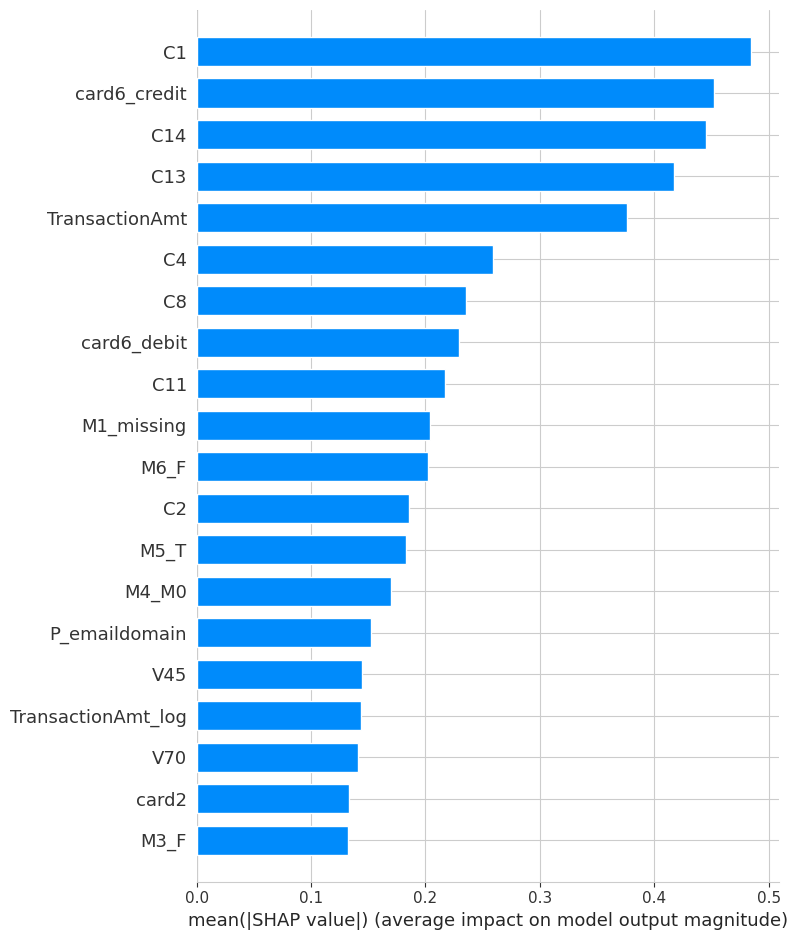

In [ ]:
# CELL 16 - SHAP summary (sample to save memory)
print("SHAP summary plotting (sampled)...")
explainer = shap.TreeExplainer(models_lgb[0])
sample_idx = np.random.choice(X_train_full.shape[0], size=min(2000, X_train_full.shape[0]), replace=False)
X_shap = X_train_full.iloc[sample_idx]
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, X_shap, plot_type='bar', max_display=20)


In [ ]:
# CELL 17 - Predict on test (ensemble of LGB models) - FIX for meta column name mismatch
print("Predicting test set (ensemble of LGB models)...")

# 1) base LGB predictions (averaged)
preds = np.zeros(X_test.shape[0])
for m in models_lgb:
    preds += m.predict(X_test, num_iteration=m.best_iteration)
preds /= len(models_lgb)

# 2) include optional xgb and rf if they exist
have_xgb = ('xgb_cv_model' in globals() and xgb_cv_model is not None)
have_rf  = ('rf' in globals() and rf is not None)

if have_xgb:
    xgb_preds = xgb_cv_model.predict(xgb.DMatrix(X_test))
else:
    xgb_preds = None

if have_rf:
    rf_preds = rf.predict_proba(X_test)[:,1]
else:
    rf_preds = None


meta_cols_train = meta_train.columns.tolist()  # meta_train was created in Cell 14
print("Meta columns used at training:", meta_cols_train)

meta_test = pd.DataFrame(index=range(X_test.shape[0]))

# Fill columns consistently
if 'lgb_oof' in meta_cols_train:
    meta_test['lgb_oof'] = preds
elif 'lgb' in meta_cols_train:
    meta_test['lgb'] = preds
else:
    # fallback: create 'lgb_oof' to match common naming
    meta_test['lgb_oof'] = preds

if 'xgb_oof' in meta_cols_train:
    meta_test['xgb_oof'] = xgb_preds if xgb_preds is not None else preds
elif 'xgb' in meta_cols_train:
    meta_test['xgb'] = xgb_preds if xgb_preds is not None else preds

if 'rf_oof' in meta_cols_train:
    meta_test['rf_oof'] = rf_preds if rf_preds is not None else preds
elif 'rf' in meta_cols_train:
    meta_test['rf'] = rf_preds if rf_preds is not None else preds

# Ensure meta_test columns match exactly meta_train.columns order
for col in meta_cols_train:
    if col not in meta_test.columns:
        # if a column is missing, fill with preds (safe fallback)
        meta_test[col] = preds
meta_test = meta_test[meta_cols_train]

print("Meta test columns prepared:", list(meta_test.columns))

# 4) final prediction using meta model if exists, otherwise use preds
if 'meta_clf' in globals():
    final_preds = meta_clf.predict_proba(meta_test)[:,1]
    print("Used meta_clf for final predictions.")
else:
    final_preds = preds
    print("meta_clf not found — using averaged LGB predictions as final_preds.")

# sanity checks
print("final_preds sample:", final_preds[:5])


Predicting test set (ensemble of LGB models)...
Meta columns used at training: ['lgb_oof', 'xgb_oof', 'rf_oof']
Meta test columns prepared: ['lgb_oof', 'xgb_oof', 'rf_oof']
Used meta_clf for final predictions.
final_preds sample: [0.02893173 0.03056844 0.03437602 0.02675499 0.03806438]


In [ ]:
# CELL 18 - Save submission
submission = pd.DataFrame({'TransactionID': test_ids, 'isFraud': final_preds})
submission.to_csv(SUBMIT_PATH, index=False)
print("Submission saved to:", SUBMIT_PATH)
display(submission.head())


Submission saved to: /content/drive/MyDrive/ML/submission_lgb_stacked.csv


,TransactionID,isFraud
0,3663549,0.028932
1,3663550,0.030568
2,3663551,0.034376
3,3663552,0.026755
4,3663553,0.038064


In [ ]:
# CELL 19 - Auto report snippet
print("REPORT SNIPPET:")
print(f"- Primary model: LightGBM (OOF ROC-AUC: {roc_auc_score(y_train_full, oof):.4f}, PR-AUC: {average_precision_score(y_train_full, oof):.4f})")
if not FAST_MODE:
    print("- Secondary: XGBoost & RandomForest used in stacking (light).")
print("- Feature engineering: TransactionAmt_log, DT_hour, DT_day, card combos.")
print("- Imbalance handling: RandomUnderSampler + small SMOTE (memory safe).")
print("- Explainability: SHAP on LightGBM (top features saved).")
print("- Recommendation: use threshold selection based on business cost (FN > FP costs).")


REPORT SNIPPET:
- Primary model: LightGBM (OOF ROC-AUC: 0.9757, PR-AUC: 0.9798)
- Secondary: XGBoost & RandomForest used in stacking (light).
- Feature engineering: TransactionAmt_log, DT_hour, DT_day, card combos.
- Imbalance handling: RandomUnderSampler + small SMOTE (memory safe).
- Explainability: SHAP on LightGBM (top features saved).
- Recommendation: use threshold selection based on business cost (FN > FP costs).


In [ ]:
# CELL 20 - Cleanup memory
del train, test, train_enc, test_enc, X_train_full
gc.collect()
print("Done. Memory cleaned.")


Done. Memory cleaned.
